In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import html
import re
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
#download pretrained pipeline package

spacy.cli.download("en_core_web_md")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 13.9 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Load Dataset

In [5]:
data = pd.read_csv('../data/reddit_posts_comments.csv')
data.head()

,post_id,title,content,created_utc,subreddit,comments
0,1fzfb8t,Will Trump or Kamala Harris win key swing stat...,NaN,1.728435e+09,technology,['I asked AI how to clean a cast iron pan and ...
1,1fyxmo4,Nobel Prize in physics awarded to 2 scientists...,NaN,1.728387e+09,technology,[]
2,1fz0m72,Adobe has a new tool to protect artists’ work ...,NaN,1.728396e+09,technology,"['The irony... Adobe stole from, pardon ""opted..."
3,1fc2c3m,Stellantis And Tesla Hit Rock Bottom In CR’s U...,NaN,1.725814e+09,technology,['How can Stellantis (Chrysler/Jeep/Ram) hit r...
4,1fc2ufg,Analysis of thousands of channels reveals Tele...,NaN,1.725816e+09,technology,"['Funny part, these days Telegram is the only ..."


## Data Cleaning

In [7]:
data.columns

Index(['post_id', 'title', 'content', 'created_utc', 'subreddit', 'comments'], dtype='object')

In [8]:
data.shape

(8306, 6)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8306 entries, 0 to 8305
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   post_id      8306 non-null   object 
 1   title        8306 non-null   object 
 2   content      119 non-null    object 
 3   created_utc  8306 non-null   float64
 4   subreddit    8306 non-null   object 
 5   comments     8306 non-null   object 
dtypes: float64(1), object(5)
memory usage: 389.5+ KB


In [10]:
data.isna().sum()

post_id           0
title             0
content        8187
created_utc       0
subreddit         0
comments          0
dtype: int64

it turns out most of the  Reddit posts, consist only of titles with links or short statements, rather than full body text or detailed explanations. Therefore, we can drop the content column

In [12]:
#drop content column 
data.drop(columns= 'content',inplace=True)
data.head()

,post_id,title,created_utc,subreddit,comments
0,1fzfb8t,Will Trump or Kamala Harris win key swing stat...,1.728435e+09,technology,['I asked AI how to clean a cast iron pan and ...
1,1fyxmo4,Nobel Prize in physics awarded to 2 scientists...,1.728387e+09,technology,[]
2,1fz0m72,Adobe has a new tool to protect artists’ work ...,1.728396e+09,technology,"['The irony... Adobe stole from, pardon ""opted..."
3,1fc2c3m,Stellantis And Tesla Hit Rock Bottom In CR’s U...,1.725814e+09,technology,['How can Stellantis (Chrysler/Jeep/Ram) hit r...
4,1fc2ufg,Analysis of thousands of channels reveals Tele...,1.725816e+09,technology,"['Funny part, these days Telegram is the only ..."


In [13]:
#change the created utc to readable date format
data['created_utc'] = pd.to_datetime(data['created_utc'], unit='s')
data.head()

,post_id,title,created_utc,subreddit,comments
0,1fzfb8t,Will Trump or Kamala Harris win key swing stat...,2024-10-09 00:45:16,technology,['I asked AI how to clean a cast iron pan and ...
1,1fyxmo4,Nobel Prize in physics awarded to 2 scientists...,2024-10-08 11:37:11,technology,[]
2,1fz0m72,Adobe has a new tool to protect artists’ work ...,2024-10-08 14:05:54,technology,"['The irony... Adobe stole from, pardon ""opted..."
3,1fc2c3m,Stellantis And Tesla Hit Rock Bottom In CR’s U...,2024-09-08 16:50:16,technology,['How can Stellantis (Chrysler/Jeep/Ram) hit r...
4,1fc2ufg,Analysis of thousands of channels reveals Tele...,2024-09-08 17:12:16,technology,"['Funny part, these days Telegram is the only ..."


In [14]:
#check for duplicates
data['post_id'].nunique()#which is same as the number of observations in the dataset


8306

In [15]:
data['subreddit'].value_counts()

subreddit
technology    5143
gadgets       3163
Name: count, dtype: int64

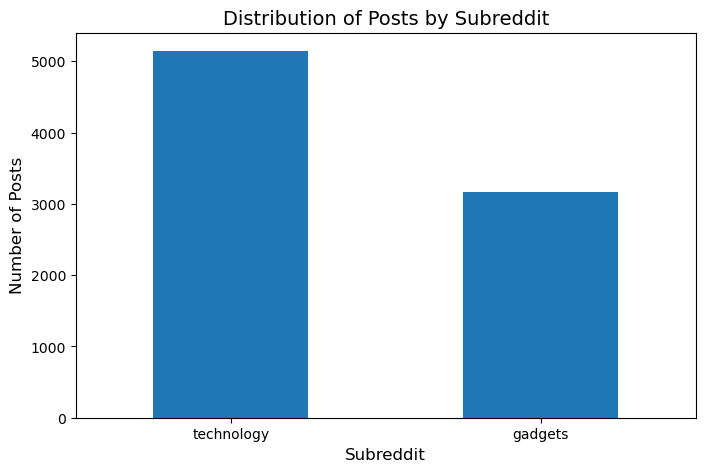

In [55]:

data['title_length'] = data['title'].apply(len)

# calculate the average title length per subreddit
avg_title_length_per_subreddit = data.groupby('subreddit')['title_length'].mean().reset_index()

plt.figure(figsize=(8, 5))
data['subreddit'].value_counts().plot(kind='bar')
plt.title('Distribution of Posts by Subreddit', fontsize=14)
plt.xlabel('Subreddit', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
plt.xticks(rotation=0)
plt.savefig('../img/Distribution_of_Posts.png')


The bar chart above shows the distribution of posts across the two subreddits. technology has more posts compared to gadgets.

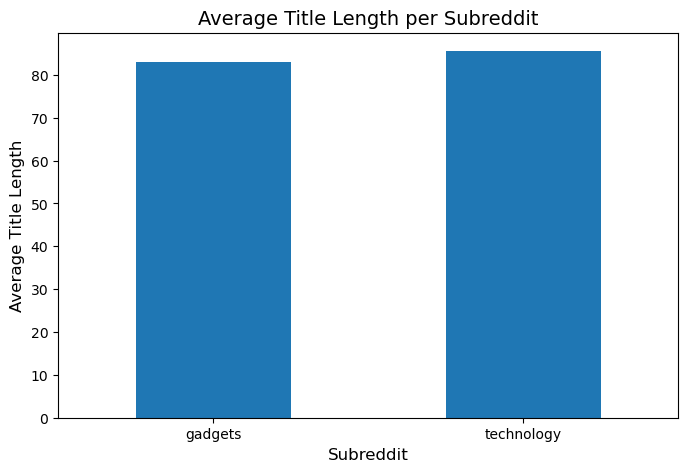

In [18]:

# calculate average title length per subreddit
data['title_length'] = data['title'].apply(len)
avg_title_length_per_subreddit = data.groupby('subreddit')['title_length'].mean()

plt.figure(figsize=(8, 5))
avg_title_length_per_subreddit.plot(kind='bar')
plt.title('Average Title Length per Subreddit', fontsize=14)
plt.xlabel('Subreddit', fontsize=12)
plt.ylabel('Average Title Length', fontsize=12)
plt.xticks(rotation=0);


## Data Processing

In [20]:

#load medium pipeline
nlp = spacy.load('en_core_web_md')

In [21]:

def clean_text(text):
    # remove URLs, emoticons, HTML tags, and entities 
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'[:;=][\-~]?[)(DP]', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = html.unescape(text)

    
    text = text.lower()
    text = re.sub(r'[\d]', '', text)  # remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation

    # tokenize, remove stop words, and lemmatize using SpaCy
    doc = nlp(text)
    clean_tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in STOP_WORDS]

    return ' '.join(clean_tokens)


In [22]:
#preprocess title
data['processed_title'] = data['title'].apply(lambda x: clean_text(x))
# preprocess comments
data['processed_comments'] = data['comments'].apply(clean_text)

data.head()


,post_id,title,created_utc,subreddit,comments,title_length,processed_title,processed_comments
0,1fzfb8t,Will Trump or Kamala Harris win key swing stat...,2024-10-09 00:45:16,technology,['I asked AI how to clean a cast iron pan and ...,72,trump kamala harris win key swing state ask ch...,ask ai clean cast iron pan tell mix bleach amm...
1,1fyxmo4,Nobel Prize in physics awarded to 2 scientists...,2024-10-08 11:37:11,technology,[],99,nobel prize physics award scientist discovery ...,
2,1fz0m72,Adobe has a new tool to protect artists’ work ...,2024-10-08 14:05:54,technology,"['The irony... Adobe stole from, pardon ""opted...",53,adobe new tool protect artist work ai,irony adobe steal pardon opt creative datum gr...
3,1fc2c3m,Stellantis And Tesla Hit Rock Bottom In CR’s U...,2024-09-08 16:50:16,technology,['How can Stellantis (Chrysler/Jeep/Ram) hit r...,80,stellantis tesla hit rock crs car brand reliab...,stellantis chryslerjeepram hit rock rock delete
4,1fc2ufg,Analysis of thousands of channels reveals Tele...,2024-09-08 17:12:16,technology,"['Funny part, these days Telegram is the only ...",85,analysis thousand channel reveal telegram floo...,funny day telegram widely message platform end...


In [23]:
# combine the 'processed_title' and 'processed_comments' columns
data['processed_text'] = data['processed_title'] + ' ' + data['processed_comments']

data.head()



,post_id,title,created_utc,subreddit,comments,title_length,processed_title,processed_comments,processed_text
0,1fzfb8t,Will Trump or Kamala Harris win key swing stat...,2024-10-09 00:45:16,technology,['I asked AI how to clean a cast iron pan and ...,72,trump kamala harris win key swing state ask ch...,ask ai clean cast iron pan tell mix bleach amm...,trump kamala harris win key swing state ask ch...
1,1fyxmo4,Nobel Prize in physics awarded to 2 scientists...,2024-10-08 11:37:11,technology,[],99,nobel prize physics award scientist discovery ...,,nobel prize physics award scientist discovery ...
2,1fz0m72,Adobe has a new tool to protect artists’ work ...,2024-10-08 14:05:54,technology,"['The irony... Adobe stole from, pardon ""opted...",53,adobe new tool protect artist work ai,irony adobe steal pardon opt creative datum gr...,adobe new tool protect artist work ai irony ad...
3,1fc2c3m,Stellantis And Tesla Hit Rock Bottom In CR’s U...,2024-09-08 16:50:16,technology,['How can Stellantis (Chrysler/Jeep/Ram) hit r...,80,stellantis tesla hit rock crs car brand reliab...,stellantis chryslerjeepram hit rock rock delete,stellantis tesla hit rock crs car brand reliab...
4,1fc2ufg,Analysis of thousands of channels reveals Tele...,2024-09-08 17:12:16,technology,"['Funny part, these days Telegram is the only ...",85,analysis thousand channel reveal telegram floo...,funny day telegram widely message platform end...,analysis thousand channel reveal telegram floo...


## EDA:

In [25]:
# summary statistics for numeric columns
summary_statistics = data.describe()
summary_statistics

,created_utc,title_length
count,8306,8306.000000
mean,2021-05-16 01:16:18.121237760,84.583915
min,2008-01-15 17:55:32,4.000000
25%,2019-07-06 09:18:17,59.000000
50%,2023-11-25 16:04:46,73.000000
75%,2024-07-25 12:48:32.500000,96.000000
max,2024-10-09 13:53:18,304.000000
std,NaN,42.630507


In [26]:
data.isna().sum()

post_id               0
title                 0
created_utc           0
subreddit             0
comments              0
title_length          0
processed_title       0
processed_comments    0
processed_text        0
dtype: int64

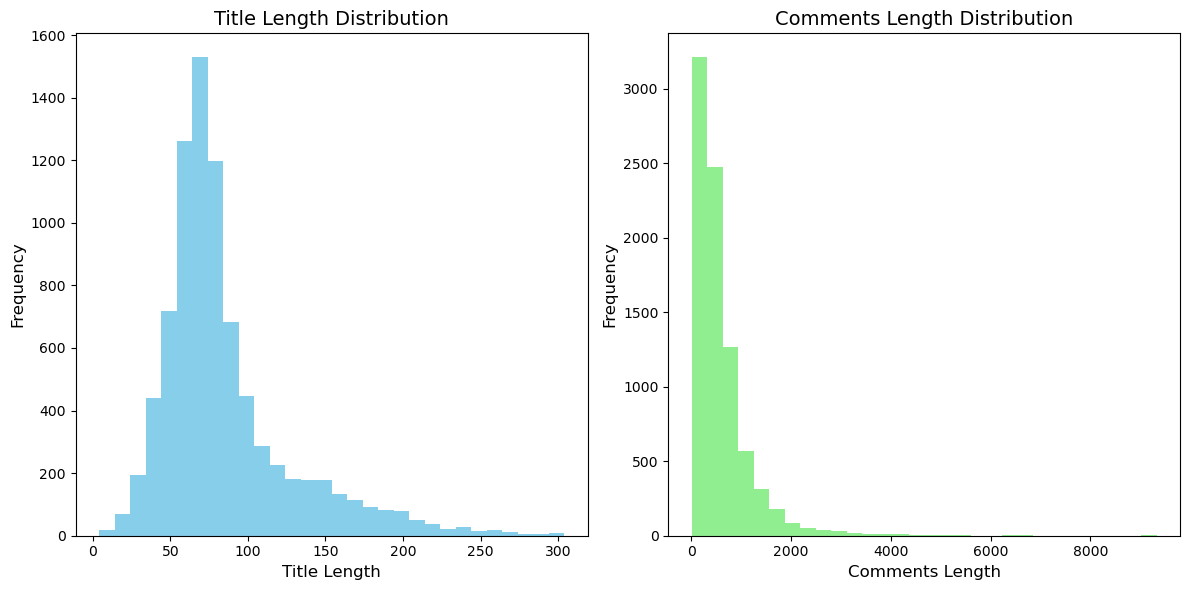

In [27]:
#analyze the length of titles and comments 
# create new columns to store the length of titles and comments
data['title_length'] = data['title'].apply(len)
data['comments_length'] = data['comments'].apply(len)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(data['title_length'], bins=30, color='skyblue')
plt.title('Title Length Distribution', fontsize=14)
plt.xlabel('Title Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(1, 2, 2)
plt.hist(data['comments_length'], bins=30, color='lightgreen')
plt.title('Comments Length Distribution', fontsize=14)
plt.xlabel('Comments Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()



 Most titles are relatively short, with many under 150 characters.The comments have a wider distribution, with many posts having longer comments, some exceeding 1,000 characters.

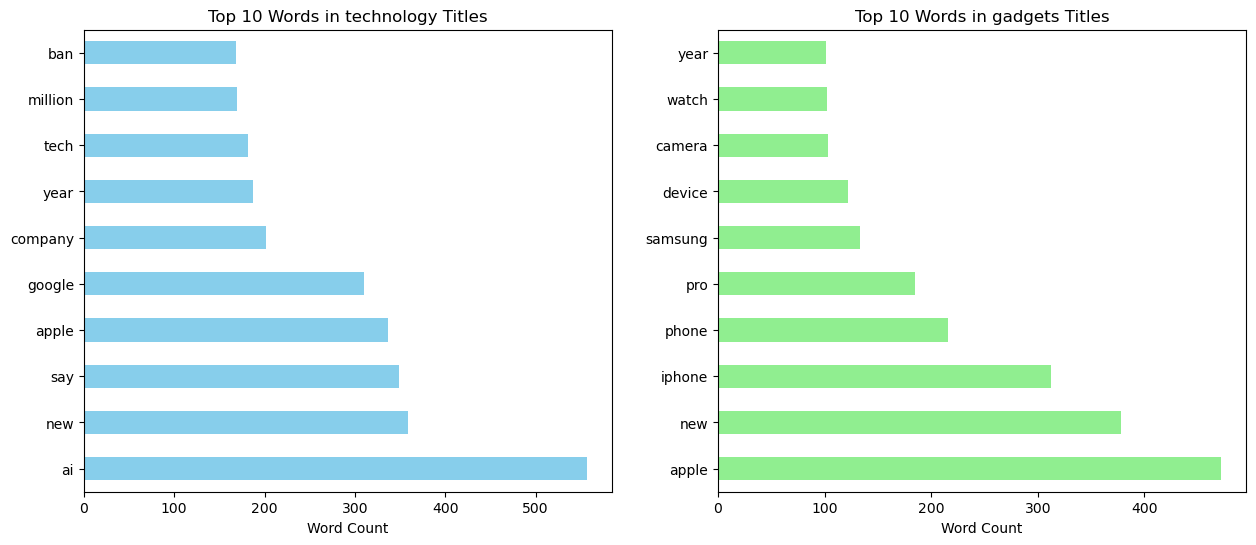

In [29]:
#most frequent words in the titles subreddits

def get_top_n_words(subreddit, n=10):
    # filter the data for the specific subreddit
    subreddit_data = data[data['subreddit'] == subreddit]['processed_title']
    
    # CountVectorizer for the titles
    vectorizer = CountVectorizer(stop_words='english')
    word_counts = vectorizer.fit_transform(subreddit_data)
    
    # dataFrame of the word counts
    common_words_df = pd.DataFrame(data=word_counts.toarray(), columns=vectorizer.get_feature_names_out())
    common_words_sum = common_words_df.sum().sort_values(ascending=False)
    return common_words_sum.head(n)

#  top 10 words for technology and gadgets titles

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
get_top_n_words('technology').plot(kind='barh', color='skyblue')
plt.title('Top 10 Words in technology Titles')
plt.xlabel('Word Count')

plt.subplot(1, 2, 2)
get_top_n_words('gadgets').plot(kind='barh', color='lightgreen')
plt.title('Top 10 Words in gadgets Titles')
plt.xlabel('Word Count');

plt.savefig('../img/Top_ten_words_in_subreddits.png')

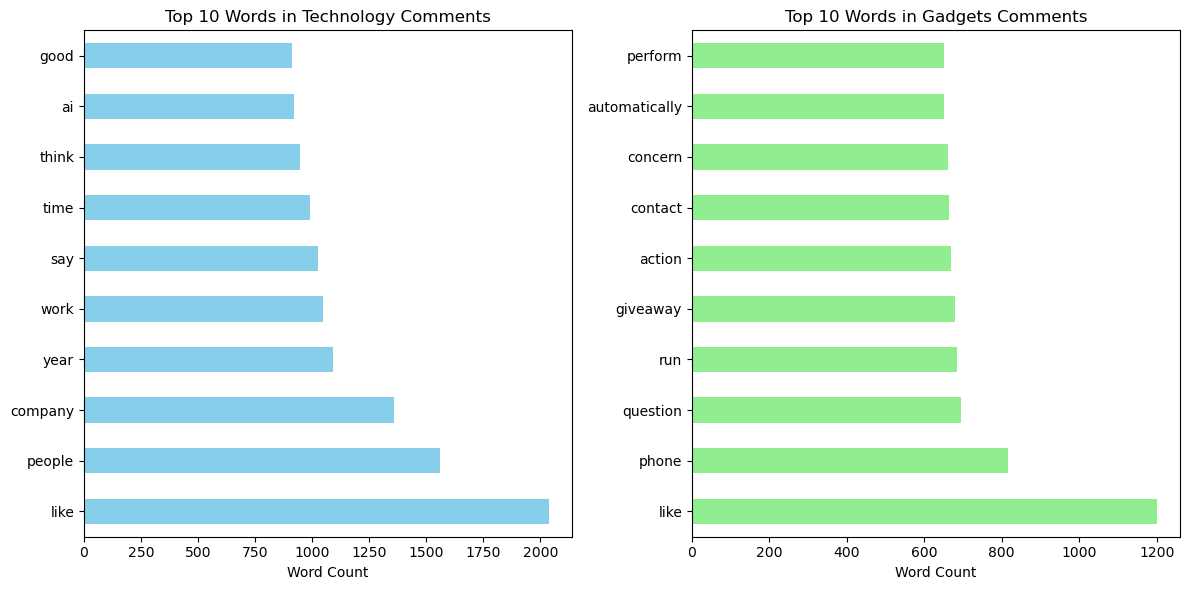

In [30]:
#most frequent words in the comments of subreddits

def get_top_n_words_comments(subreddit, n=10):
    # filter the data for the specific subreddit
    subreddit_data = data[data['subreddit'] == subreddit]['processed_comments']
    
    # CountVectorizer for the titles
    vectorizer = CountVectorizer(stop_words='english')
    word_counts = vectorizer.fit_transform(subreddit_data)
    
    # dataFrame of the word counts
    common_words_df = pd.DataFrame(data=word_counts.toarray(), columns=vectorizer.get_feature_names_out())
    common_words_sum = common_words_df.sum().sort_values(ascending=False)
    return common_words_sum.head(n)

#  top 10 words for technology and gadgets in comments

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
get_top_n_words_comments('technology').plot(kind='barh', color='skyblue')
plt.title('Top 10 Words in Technology Comments')
plt.xlabel('Word Count')

plt.subplot(1, 2, 2)
get_top_n_words_comments('gadgets').plot(kind='barh', color='lightgreen')
plt.title('Top 10 Words in Gadgets Comments')
plt.xlabel('Word Count');
plt.tight_layout()


In [59]:
## save processed dataset to csv file 
data.to_csv('../data/processed_text.csv', index=False)